# Explicabilidad

Como vimos durante los ejercicios con distintos modelos de datos, algunos de ellos muestran una estructura interpretable donde podemos entender la base sobre la que ciertas decisiones han sido tomadas. 

En otros casos, esta comprensión no es tan sencilla, de forma que los modelos que no facilitan tanto la interpretabilidad son consideradas **cajas negras**. Dentro de esta categorización los modelos basados en árboles de decision son los llamados **cajas blancas** aunque el empleo de técnicas de ensembling puede hacer que se reduzca significativamente nuestra capacidad de comprensión.

## Interpretar

Esencialmente lo que queremos entender ante una decisión tomada por un modelo es en base a qué criterios ha sido esa decisión tomada. Ya que aunque estadísticamente tenga sentido, podría resultar que debido a sesgos de los datos nuestra decisión no sea justa o ética.

## Frameworks

Algunos frameworks populares en este dominio son:

* InterpretML (https://interpret.ml/)
* Shap (https://shap.readthedocs.io/en/latest/index.html)
* Fairlearn (https://fairlearn.org/)

## Valores Shapley

Los valores Shapley (SHAP) se basan en la teoría de juegos, específicamente en el concepto de valores de Shapley, desarrollado por Lloyd S. Shapley en 1953. Esta teoría se utiliza para asignar un valor de importancia a cada característica (o “jugador”) en un modelo, midiendo su contribución a la predicción global.

![shap](https://christophm.github.io/interpretable-ml-book/images/shapley-instance-intervention.png)

**Coaliciones y agregación**
SHAP crea coaliciones de características (conjuntos de jugadores sin repetición) y calcula la contribución de cada característica a la predicción mediante la agregación de valores Shapley. Esto permite evaluar la influencia individual de cada característica en la predicción, considerando su interacción con otras características.

**Linealidad y aditividad**
Los valores SHAP se representan como un método de atribución de características aditiva y lineal. Esto significa que la contribución de cada característica se puede sumar para obtener la contribución total a la predicción. Esta propiedad lineal y aditiva facilita la interpretación de los resultados y la visualización de las explicaciones.

**Unidad atómica**
Los valores SHAP se consideran la “unidad atómica” de las interpretaciones globales. Esto significa que los valores SHAP son la base para las explicaciones locales y globales, permitiendo una comprensión coherente y objetiva de cómo cada característica influye en la predicción.

**Transferible a modelos no lineales**
Aunque la teoría de juegos se basa en suposiciones lineales, los valores SHAP se pueden aplicar a modelos no lineales, como modelos de árboles o redes neuronales, mediante aproximaciones y optimizaciones. Esto permite extender la explicabilidad a un amplio rango de modelos de machine learning.

Probemos qué pinta tienen de forma práctica.

In [1]:
# !pip install shap

In [1]:
import shap
import sklearn

# información de la vivienda en california
X, y = shap.datasets.california(n_points=1000)

# 100 muestras aleatorias sobre la distribución original
X100 = shap.utils.sample(X, 100)

# Un simple modelo lineal
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [2]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


Aunque los coeficientes son excelentes para saber qué ocurrirá cuando cambiemos el valor de una característica de entrada, por sí solos no son una buena forma de medir la importancia global de una característica.

Esto se debe a que el valor de cada coeficiente depende de la escala de las características de entrada. Si, por ejemplo, midiéramos la antigüedad de una casa en minutos en lugar de en años, los coeficientes de la característica HouseAge serían 0,0115 / (365∗24∗60) = 2,18e-8.

Es evidente que el número de años transcurridos desde que se construyó una casa no es más importante que el número de minutos, y sin embargo su valor de coeficiente es mucho mayor. Esto significa que la magnitud de un coeficiente no es necesariamente una buena medida de la importancia de una característica en un modelo lineal. Esta es una de las razones por las que el escalado de los datos es un factor importante a la hora de interpretar la relevancia basado en los coeficientes asignados.

Para entender la importancia de una característica en un modelo, es necesario comprender cómo afecta el cambio de esa característica a los resultados del modelo y también la distribución de los valores de esa característica. Para visualizar esto en un modelo lineal, podemos construir un gráfico de dependencia parcial clásico y mostrar la distribución de los valores de las características como un histograma en el eje x:

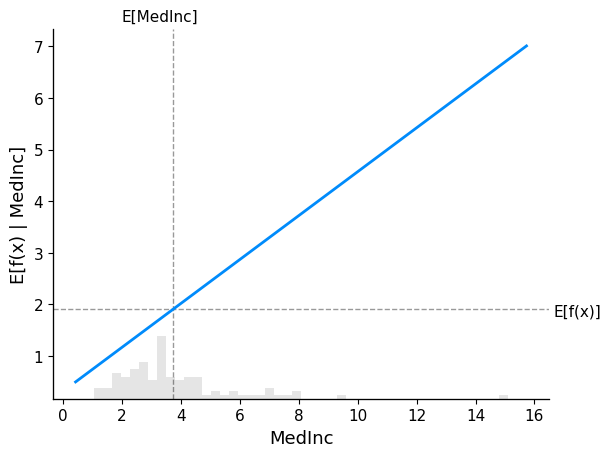

In [3]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

La línea horizontal gris del gráfico anterior representa el valor esperado del modelo cuando se aplica al conjunto de datos de vivienda de California. La línea vertical gris representa el valor medio de la mediana de ingresos. 

Observad que la línea azul del gráfico de dependencia parcial (que es el valor medio de la salida del modelo cuando fijamos la característica de renta mediana en un valor determinado) siempre pasa por la intersección de las dos líneas grises de valor esperado. Podemos considerar este punto de intersección como el **centro** del gráfico de dependencia parcial con respecto a la distribución de los datos.

El impacto de este centrado quedará claro cuando pasemos a los valores de Shapley a continuación.

En la raíz de los valores Shapley reside en el valor condicional de la predicción dado un subconjunto del dataset original:

$$

E\left[ f(x) | X_s = x_s\right]

$$

Los valores SHAP pueden ser muy complicados de calcular (en general, son NP-hard), pero los modelos lineales son tan sencillos que podemos leer los valores SHAP directamente en un gráfico de dependencia parcial. Cuando explicamos una predicción  $f(X)$, el valor SHAP de una característica concreta 
 no es más que la diferencia entre el resultado esperado del modelo y el gráfico de dependencia parcial en el valor de la característica:

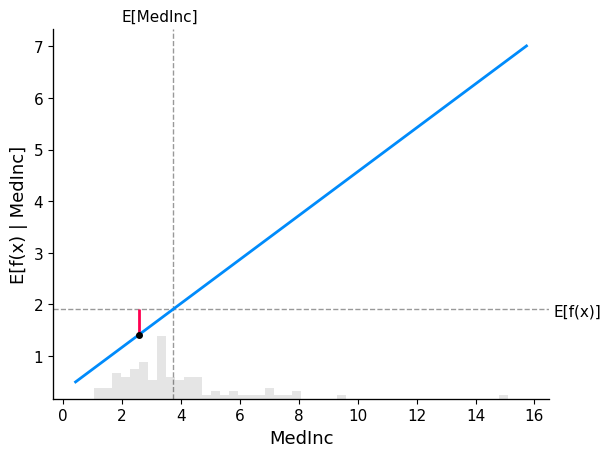

In [4]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

Realizando esta operación para cada característica podemos obtener un gráfico de cascada sobre la relevancia de cada variable. Dado el valor esperado de la variable objetivo $E\left[ f(X)\right]$ podemos observar la contribución de las distintas variables a la obtención del valor $f(x)$.

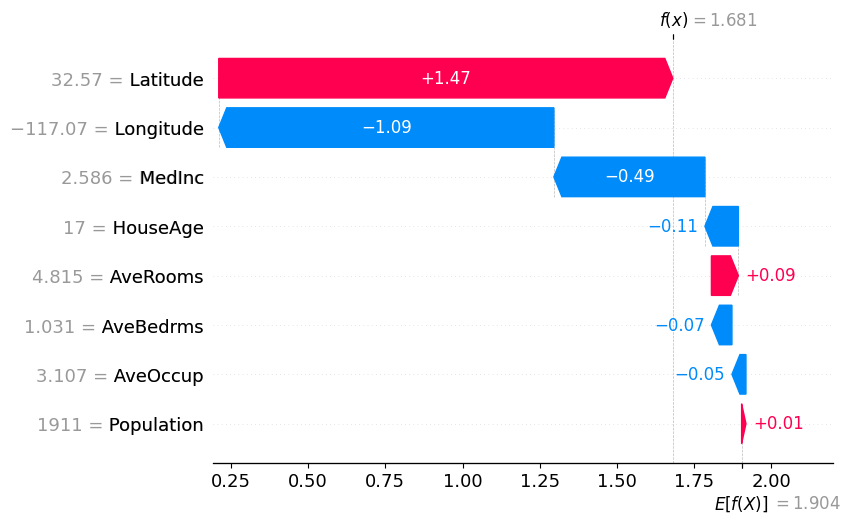

In [5]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

### InterpretML

Entre los modelos explicativos que nos ofrecen librerías como [InterpretML](https://interpret.ml/docs/), los Explainable Boosting Machines (EBM) ofrecen una capa adicional de explicabilidad sobre otras técnicas de boosting más comunes.

EBM es un modelo interpretable desarrollado en Microsoft Research. Utiliza técnicas modernas de aprendizaje automático, como bagging, gradient boosting y detección automática de interacciones, para insuflar nueva vida a los GAM (modelos aditivos generalizados) tradicionales. Esto hace que los EBM sean tan precisos como las técnicas más avanzadas, como los Random Forest y los Gradient Boosted Trees. Sin embargo, a diferencia de estos modelos de caja negra, los EBM producen explicaciones exactas y pueden ser editados por expertos en la materia.

In [6]:
# !pip install interpret

In [7]:
import interpret.glassbox

model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

ExplainableBoostingRegressor(interactions=0)

El propio modelo nos ofrece una interfaz visual para evaluar la razón de su rendimiento.

In [8]:
from interpret import show

show(model_ebm.explain_global())

<!-- http://127.0.0.1:7001/134589794358416/ -->

In [9]:
show(model_ebm.explain_local(X[:5], y[:5]), 0)

<!-- http://127.0.0.1:7001/134592347565776/ -->

La librería Shap ofrece un complemento a la explicabilidad de cómo las variables contribuyen a las decisiones de estos modelos aditivos.

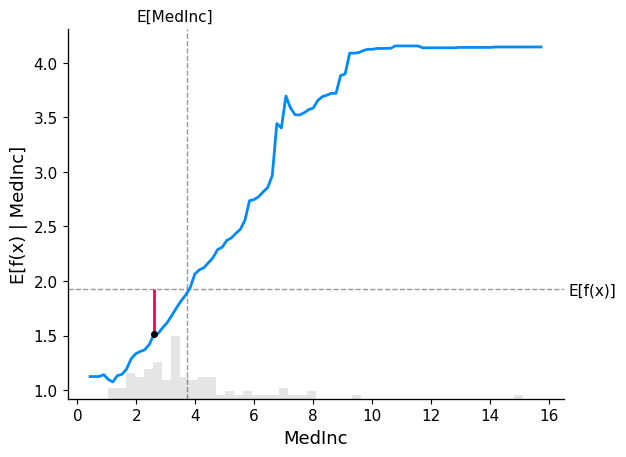

In [10]:
# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_ebm.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)

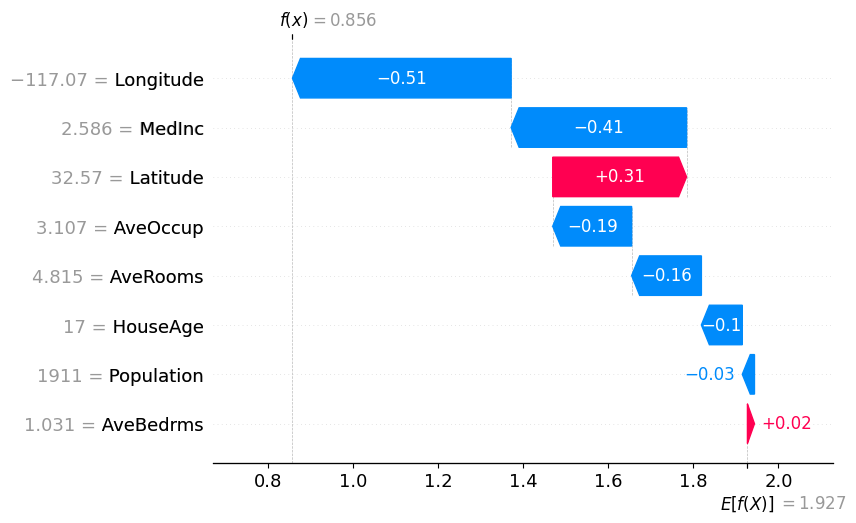

In [11]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind])

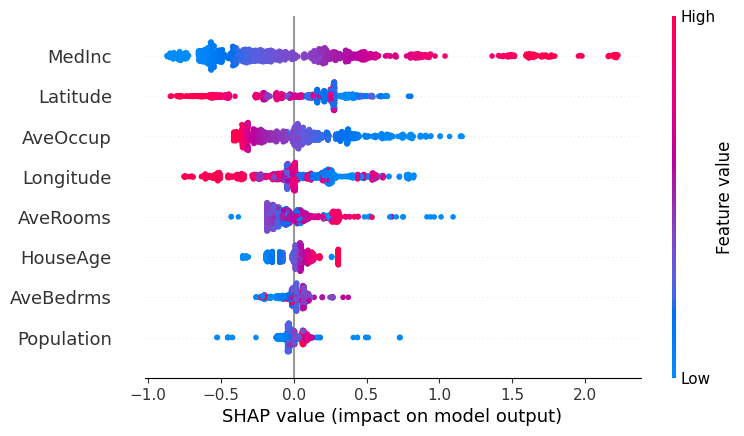

In [12]:
shap.plots.beeswarm(shap_values_ebm)

En última instancia podemos emplearlos para entender la contribución en modelos más difíciles de interpretar de por si.

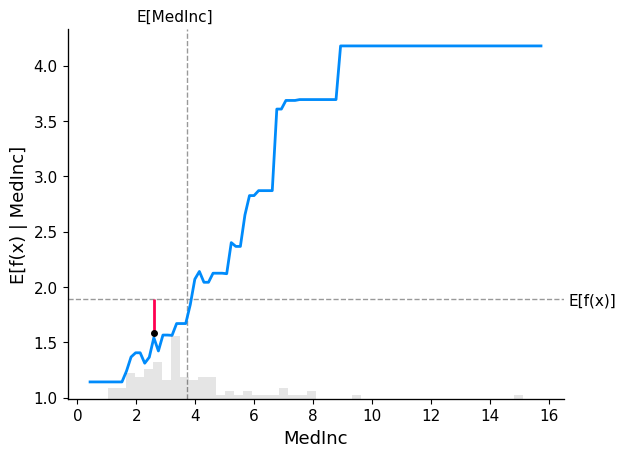

In [13]:
# train XGBoost model
import xgboost

model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_xgb.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)

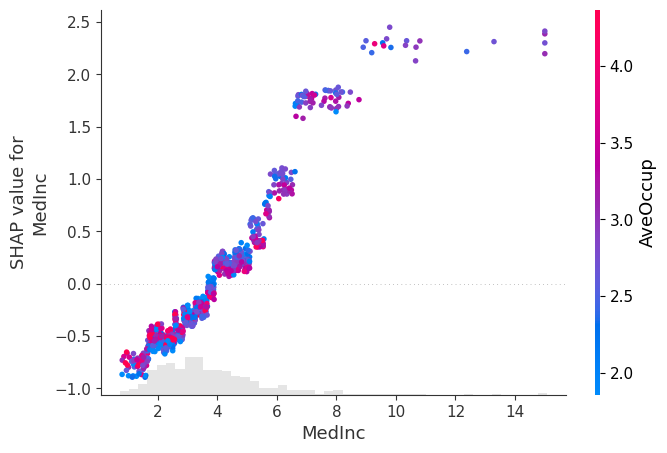

In [14]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"], color=shap_values)

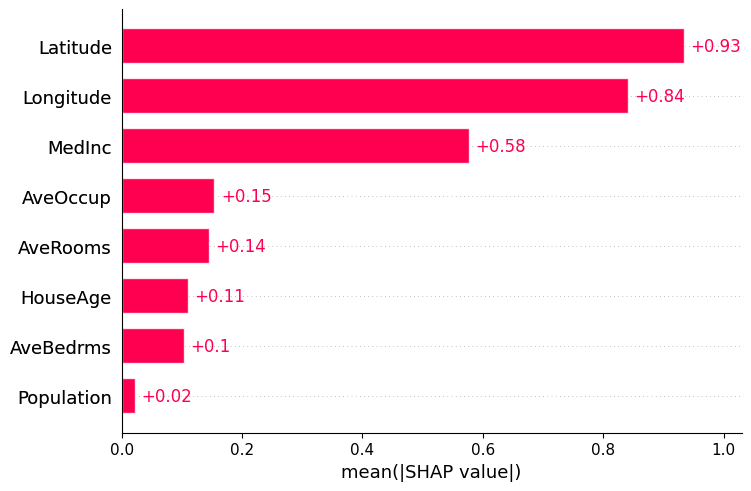

In [15]:
shap.plots.bar(shap_values)

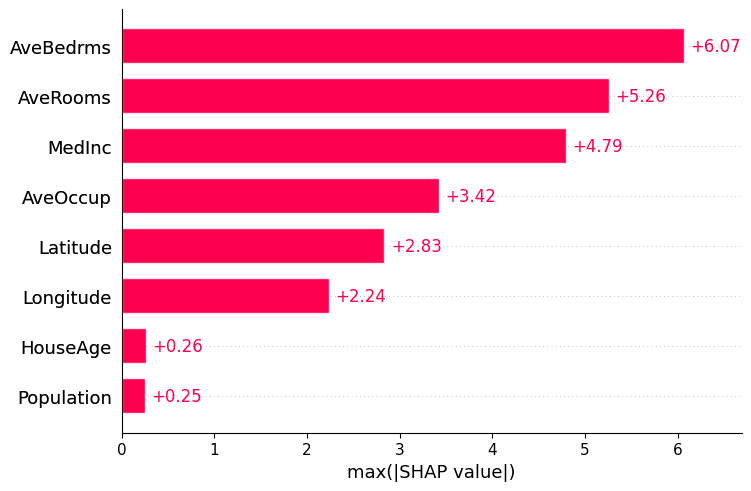

In [16]:
shap.plots.bar(shap_values.abs.max(0))

Incluso podemos usar estos valores para entender qué partes de una imagen influyeron en la decisión de una [red neuronal convolucional](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html#Visualizing-SHAP-values-output).

## Fairness

Poder evaluar lo justo que es nuestro modelo ante diferentes audiencias será clave en entornos regulados o con un especial interés en no generar desigualdades entre nuestros clientes. Para ello, disponemos de librerías que nos facilitan la tarea de evaluar estos aspectos.

In [17]:
# !pip install fairlearn

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

data = fetch_adult(as_frame=True)
data.data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [19]:
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']
sex.value_counts()

sex
Male      32650
Female    16192
Name: count, dtype: int64

Vemos que hay un desbalance importante en nuestra base de datos. Supongamos que seguimos adelante sin prestar mucha atención a este aspecto.

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)

y_pred = classifier.predict(X)
accuracy_score(y_pred=y_pred, y_true=y_true)

0.8443552680070431

In [22]:
from fairlearn.metrics import MetricFrame

mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
mf.overall

0.8443552680070431

In [23]:
mf.by_group

sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: float64

A priori parece que tenemos un buen clasificador incluso por clase. Pero si vemos por ejemplo, cual es nuestro rango de población con etiqueta positiva (1).

In [24]:
from fairlearn.metrics import selection_rate

sr = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
sr.overall

0.16385487899758405

In [25]:
sr.by_group

sex
Female    0.063550
Male      0.213599
Name: selection_rate, dtype: float64

Vemos que hay un ratio muy desfavorable hacia una de los grupos considerados. De hecho, podemos mostrar varias de estas métricas en conjunto para entender mejor la disparidad generada.

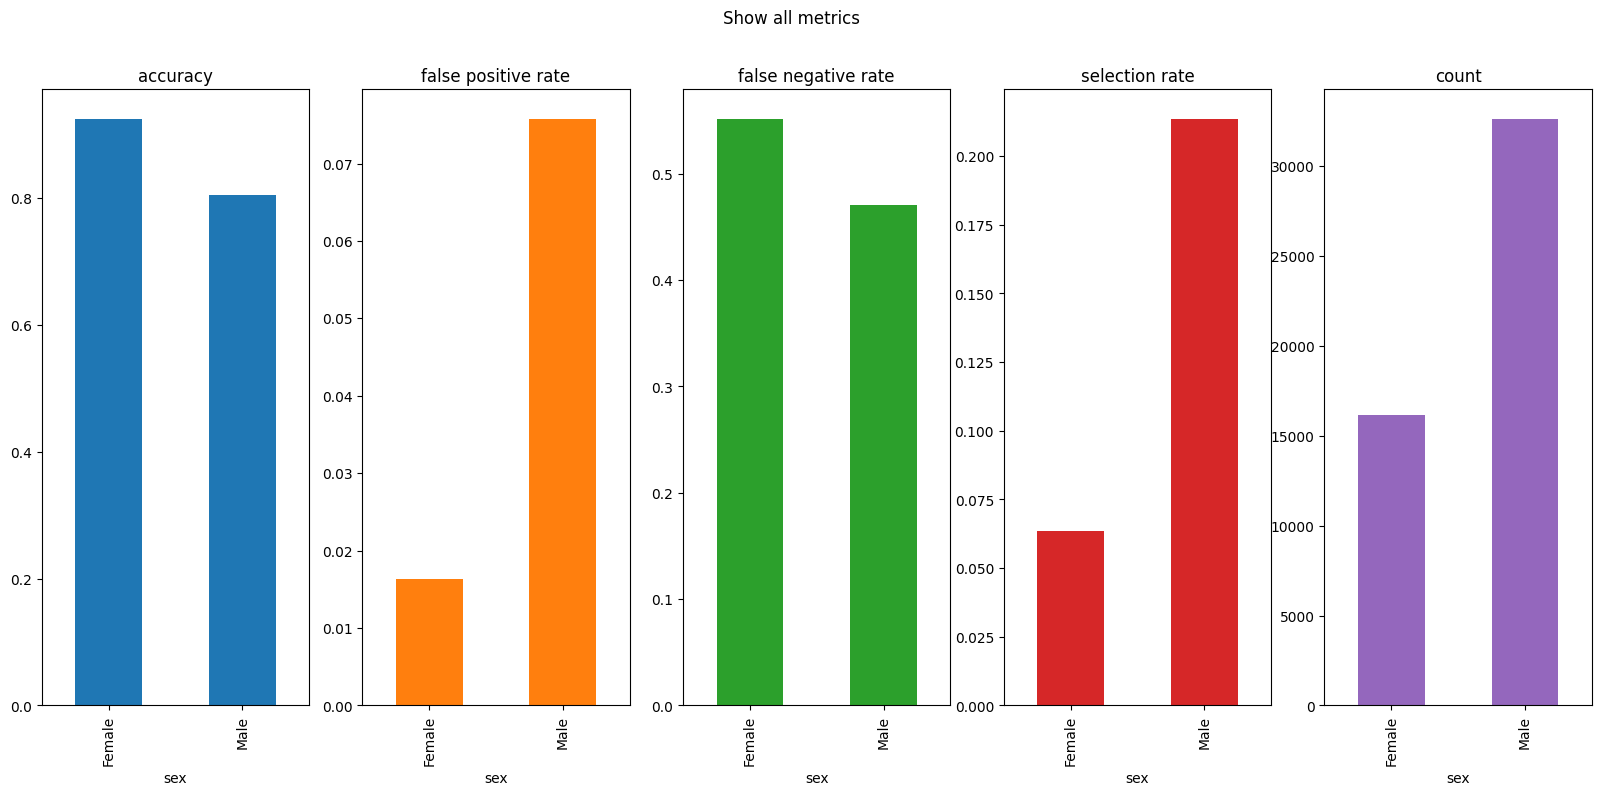

In [26]:
from fairlearn.metrics import *

metrics = {
    "accuracy": accuracy_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 5],
    legend=False,
    figsize=[20, 8],
    title="Show all metrics",
);


Fairlean permite realizar una mitigación de cara a disponer de un modelo más justo.

In [27]:
import warnings
from fairlearn.reductions import DemographicParity, ExponentiatedGradient

warnings.filterwarnings(action="ignore")
np.random.seed(0)

constraint = DemographicParity()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7a6898513ad0>,
                      estimator=DecisionTreeClassifier(max_depth=4,
                                                       min_samples_leaf=10),
                      nu=0.0008201769357601916)

In [28]:
y_pred_mitigated = mitigator.predict(X)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)
sr_mitigated.overall

0.16614798738790384

In [29]:
sr_mitigated.by_group

sex
Female    0.155262
Male      0.171547
Name: selection_rate, dtype: float64

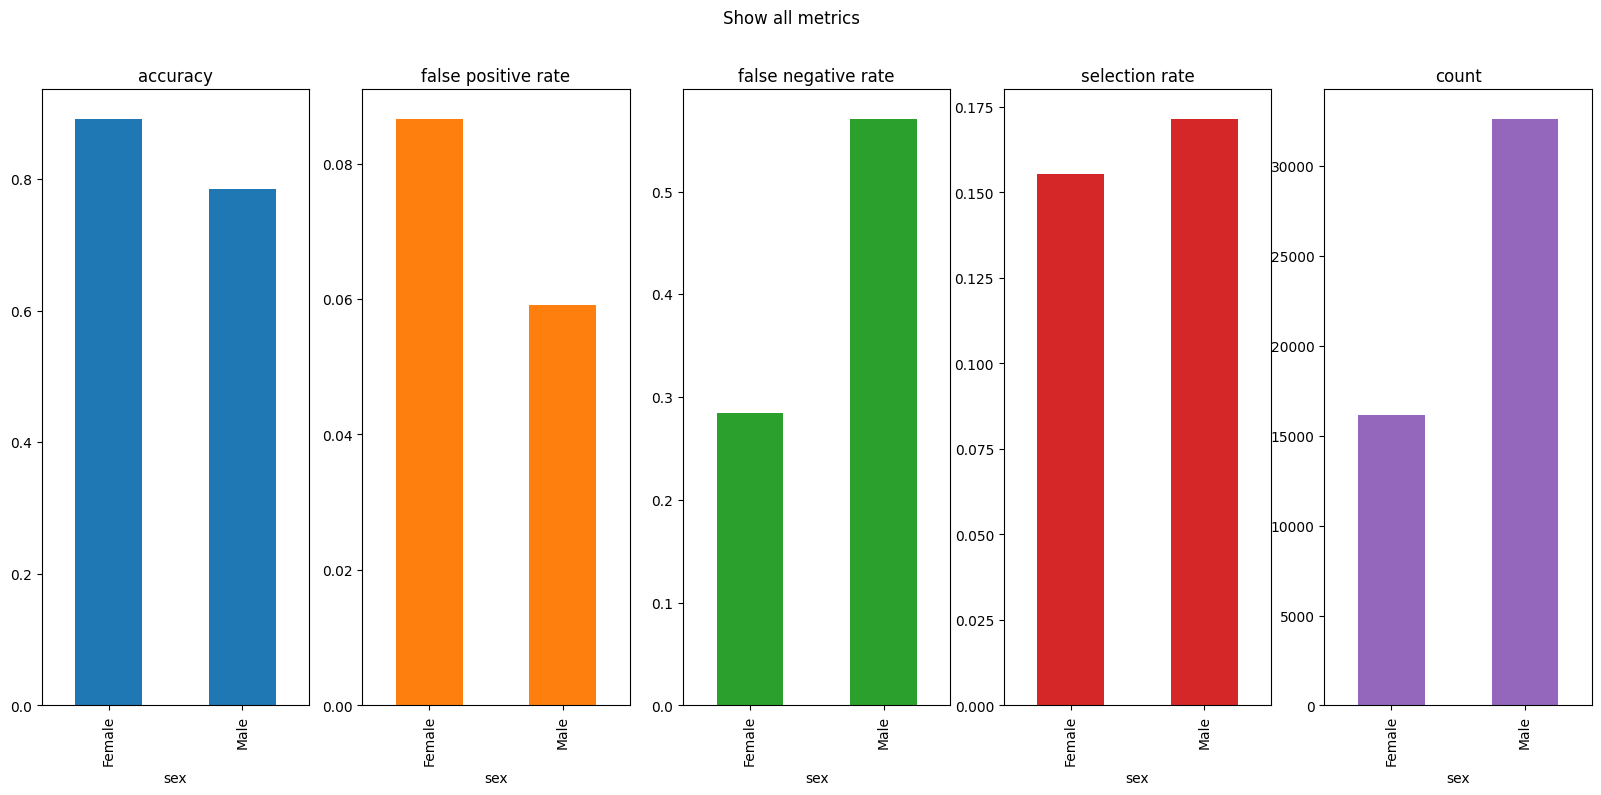

In [30]:
metrics = {
    "accuracy": accuracy_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 5],
    legend=False,
    figsize=[20, 8],
    title="Show all metrics",
);


## Referencias

* https://christophm.github.io/interpretable-ml-book/